<a href="https://colab.research.google.com/github/scpepper69/ml-learning-materials/blob/master/TensorFlow_Keras_LSTM_01_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI・機械学習 勉強会 #3
## - LSTMを用いた時系列データの予測 -


## 目次

  
2.1.   概要

2.2.   実装プロセス

1.   画像データの収集
2.   環境準備
3.   学習に向けたデータの準備
4.   モデル構築
5.   モデルの学習
6.   モデルによる予測
7.    特徴の可視化
8.   モデルのファイル出力
9.   TensorBoardでの確認


---
##3.1 概要
代表的なRNN(Recurrent Neural Network)である、LSTM(Long-Short Term Model)を用いて、時系列データの予測モデルを構築します。





---



## 3.2 実装プロセス

今回は、時系列データとして、株価を用います。

日本の自動車メーカー5社の株価の遷移をデータ化したものを用意しました。

LSTMを用いて株価予測がどの程度の精度を出せるか検証してみたいと思います。


### 3.2.1 環境準備

必要なライブラリをインポートします。

ここでは、Kerasを用いてモデルの実装を行います。

KerasではLSTMがライブラリとして実装されており、これを呼び出すだけでモデル構築が可能になっています。


In [223]:
!wget https://raw.githubusercontent.com/intel-analytics/analytics-zoo/master/pyzoo/zoo/util/tf_graph_util.py

import numpy
import matplotlib.pyplot as plt
import pandas
import math
import tensorflow as tf
from tensorflow.python.framework import graph_io
import tf_graph_util as graph_util
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


--2019-09-16 08:20:48--  https://raw.githubusercontent.com/intel-analytics/analytics-zoo/master/pyzoo/zoo/util/tf_graph_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19584 (19K) [text/plain]
Saving to: ‘tf_graph_util.py.14’

tf_graph_util.py.14 100%[===================>]  19.12K  --.-KB/s    in 0.001s  

2019-09-16 08:20:48 (33.4 MB/s) - ‘tf_graph_util.py.14’ saved [19584/19584]



In [0]:
look_back = 60
val_days = 180


### 3.2.2 データの準備

株価予測にあたってのトレーニング用データ、検証データを準備します。

本Note Bookと同一のGitHubリポジトリにサンプルデータを用意していますので、今回はこちらを使います。

データをダウンロードし、どのようなデータになっているか見てみましょう。

--2019-09-16 08:37:11--  https://raw.githubusercontent.com/scpepper69/ml-learning-materials/master/sample/stock_auto_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24705 (24K) [text/plain]
Saving to: ‘stock_auto_data.csv.22’

stock_auto_data.csv 100%[===================>]  24.13K  --.-KB/s    in 0s      

2019-09-16 08:37:11 (62.9 MB/s) - ‘stock_auto_data.csv.22’ saved [24705/24705]

     7261    7267
0  1975.5  3571.0
1  1943.0  3569.0
2  1881.5  3501.0
3  1855.0  3462.0
4  1860.5  3471.0


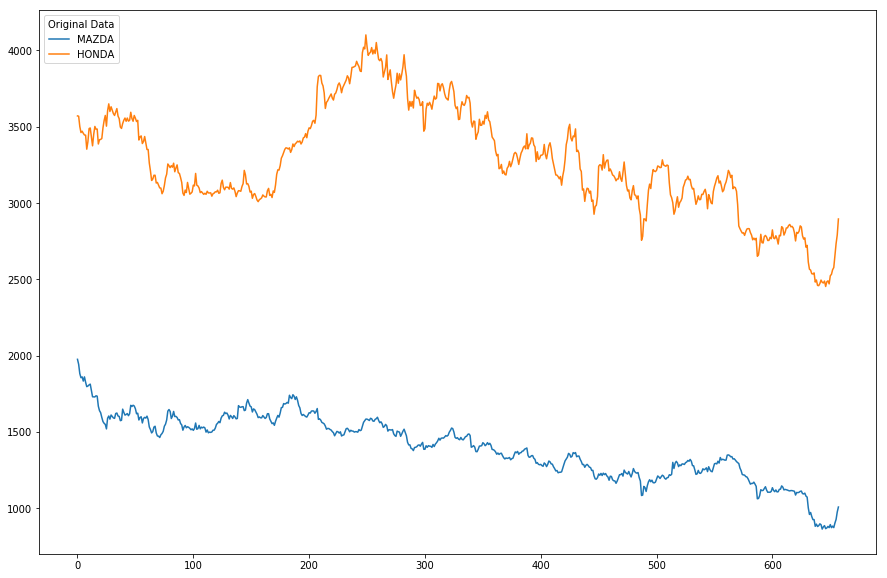

In [269]:
# 予測対象のサンプルデータを取得
!wget https://raw.githubusercontent.com/scpepper69/ml-learning-materials/master/sample/stock_auto_data.csv

#legend_list = ["MAZDA","TOYOTA","NISSAN","HONDA","SUBARU"]
legend_list = ["MAZDA","HONDA"]
    

#dataframe = pandas.read_csv('./stock_auto_data.csv', usecols=[1,2,3,4,5], engine='python', skipfooter=0).iloc[:,[2,1,0,3,4]]
dataframe = pandas.read_csv('./stock_auto_data.csv', usecols=[3,4], engine='python', skipfooter=0)
#dataframe = pandas.read_csv('./stock_auto_data.csv', usecols=[3], engine='python', skipfooter=0)
print(dataframe.head())

plt.figure(figsize=(15, 10))
p1 = plt.plot(dataframe)
l1 = plt.legend(p1,legend_list, loc='upper left', title='Original Data')

plt.show()

データに大小のばらつきが大きい場合、データの重要度が判断されてしまうと、適切な学習ができなくなります。
そのためデータを0から1までの数値に正規化します。

データの正規化に際しては、sklearnのMinMaxScalerクラスを用いて簡単に実装できます。

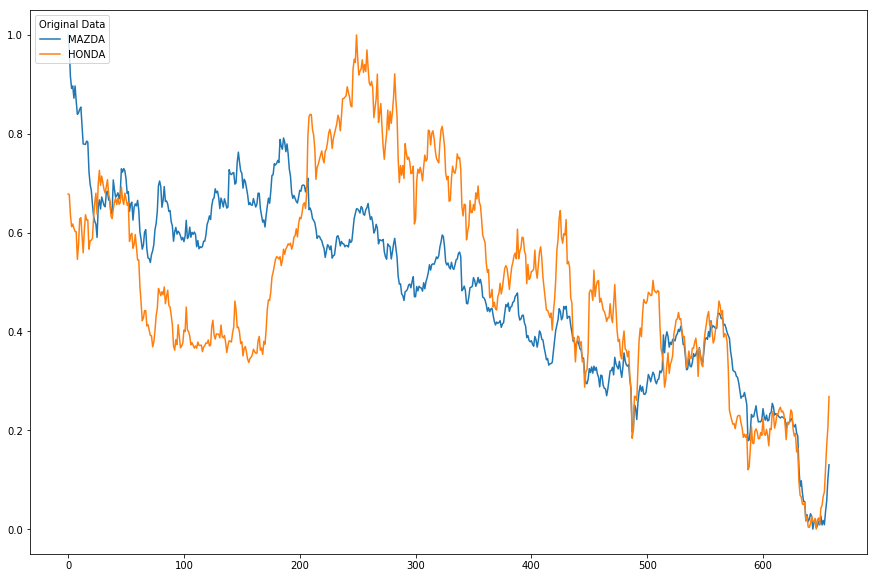

In [270]:
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = dataset.astype('float32')

plt.figure(figsize=(15, 10))
plt.plot(dataset)
plt.legend(p1,legend_list ,loc='upper left', title='Original Data')
plt.show()


データを学習用データと、検証用データに分割します。

画像分類の際はXXXXを使って分割しましたが、時系列予測の場合は、時系列であることが重要なため、手動で行います。

In [227]:
# split into train and test sets
train_size = int(len(dataset) -val_days -1)
#test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size-look_back:len(dataset),:]
print(len(dataset), len(train), len(test))

658 477 241


In [228]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=30):
    dataX, dataY = [], []
    #for i in range(len(dataset)-look_back-1):
    for i in range(len(dataset)-look_back):
        xset = []
        yset = []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+look_back), j]
            xset.append(a)
            b = dataset[i + look_back, j] #add
            yset.append(b) #add
        #dataY.append(dataset[i + look_back, 0])
        dataX.append(xset)
        dataY.append(yset) #add
    return numpy.array(dataX), numpy.array(dataY)

# convert an array of values into a dataset matrix
def create_dataset_ex(dataset, look_back=30, target_col=0):
    dataX, dataY = [], []
    #for i in range(len(dataset)-look_back-1):
    for i in range(len(dataset)-look_back):
        xset = []
        yset = []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+look_back), j]
            xset.append(a)
            if j == target_col:
                b = dataset[i + look_back, j] #add
                yset.append(b) #add
        #dataY.append(dataset[i + look_back, 0])
        dataX.append(xset)
        dataY.append(yset) #add
    return numpy.array(dataX), numpy.array(dataY)



# reshape into X=t and Y=t+1
trainX, trainY = create_dataset_ex(train, look_back)
testX, testY = create_dataset_ex(test, look_back)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)
#print(testX[0])
#print(testY)

(417, 2, 60)
(417, 1)
(181, 2, 60)
(181, 1)


In [0]:
# reshape input to be [samples, time steps(number of variables), features] *convert time series into column
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

In [230]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(400, input_shape=(trainX.shape[1], look_back))) #shape：variables,loopback time
model.add(BatchNormalization())
model.add(Dense(trainY.shape[1])) # dimension count
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(trainX, trainY, epochs=320, batch_size=16, verbose=2)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 400)               737600    
_________________________________________________________________
batch_normalization_14 (Batc (None, 400)               1600      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 401       
Total params: 739,601
Trainable params: 738,801
Non-trainable params: 800
_________________________________________________________________
Epoch 1/320
417/417 - 2s - loss: 0.0531
Epoch 2/320
417/417 - 0s - loss: 0.0091
Epoch 3/320
417/417 - 0s - loss: 0.0044
Epoch 4/320
417/417 - 0s - loss: 0.0039
Epoch 5/320
417/417 - 0s - loss: 0.0031
Epoch 6/320
417/417 - 0s - loss: 0.0023
Epoch 7/320
417/417 - 0s - loss: 0.0017
Epoch 8/320
417/417 - 0s - loss: 0.0018
Epoch 9/320
417/417 - 0s - loss: 0.0013
Epoch 10/320
41

In [0]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
pad_col = numpy.zeros(dataset.shape[1]-1)

# invert predictions
#def pad_array(val):
#    return numpy.array([numpy.insert(pad_col, 0, x) for x in val])

In [0]:
# invert predictions
#def pad_array(val):
#    return numpy.array([numpy.insert(pad_col, 0, x) for x in val])

#trainPredict = scaler.inverse_transform(pad_array(trainPredict))
#trainY = scaler.inverse_transform(pad_array(trainY))
#testPredict = scaler.inverse_transform(pad_array(testPredict))
#testY = scaler.inverse_transform(pad_array(testY))

scale=MinMaxScaler()
#scale.min_,scale.scale_ = scaler.min_[0],scaler.scale_[0]
scale.min_,scale.scale_ = scaler.min_[0],scaler.scale_[0]

#scaled_trainPredict = scaler.inverse_transform(trainPredict)
#scaled_trainY = scaler.inverse_transform(trainY)
#scaled_testPredict = scaler.inverse_transform(testPredict)
#scaled_testY = scaler.inverse_transform(testY)

scaled_trainPredict = scale.inverse_transform(trainPredict)
scaled_trainY = scale.inverse_transform(trainY)
scaled_testPredict = scale.inverse_transform(testPredict)
scaled_testY = scale.inverse_transform(testY)

In [233]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(scaled_trainY[:,0], scaled_trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(scaled_testY[:,0], scaled_testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 17.43 RMSE
Test Score: 40.62 RMSE


(659, 1)


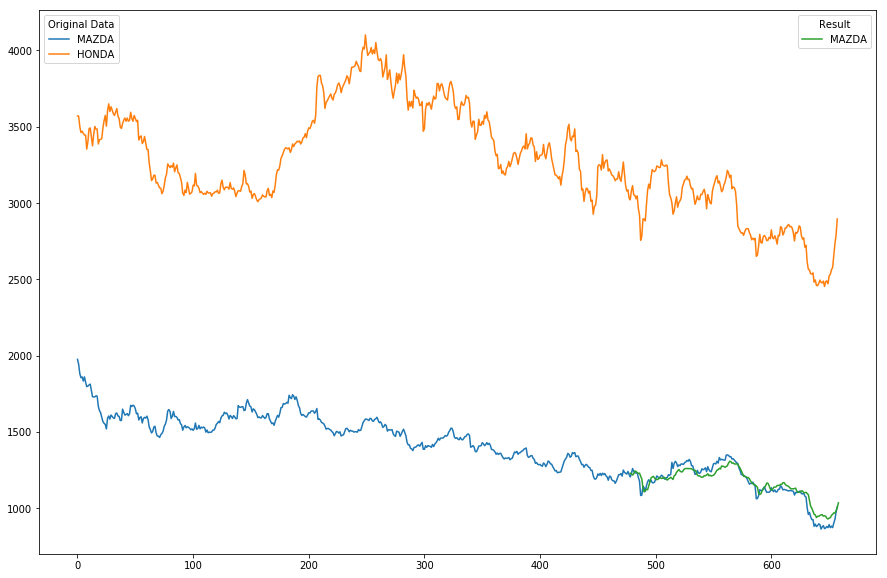

In [280]:
#print(testY[:,0])
#print(testPredict[:,0])
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(scaled_trainPredict)+look_back, :] = scaled_trainPredict
# shift test predictions for plotting
#testPredictPlot = numpy.empty_like(dataset)
testPredictPlot = numpy.empty((len(dataset)+1, trainY.shape[1]), dtype=numpy.float)
testPredictPlot[:, :] = numpy.nan
print(testPredictPlot.shape)
#testPredictPlot[len(scaled_trainPredict)+(look_back*2):len(dataset), :] = scaled_testPredict
testPredictPlot[len(dataset)-val_days:len(dataset)+1, :] = scaled_testPredict
# plot baseline and predictions
plt.figure(figsize=(15, 10))
p1 = plt.plot(scaler.inverse_transform(dataset))
#p2 = plt.plot(trainPredictPlot)
p2 = plt.plot(testPredictPlot)
l1 = plt.legend(p1, legend_list, loc='upper left', title='Original Data')
l2 = plt.legend(p2, legend_list, loc='upper right', title='Result')

plt.gca().add_artist(l1) 
plt.show()
plt.close()

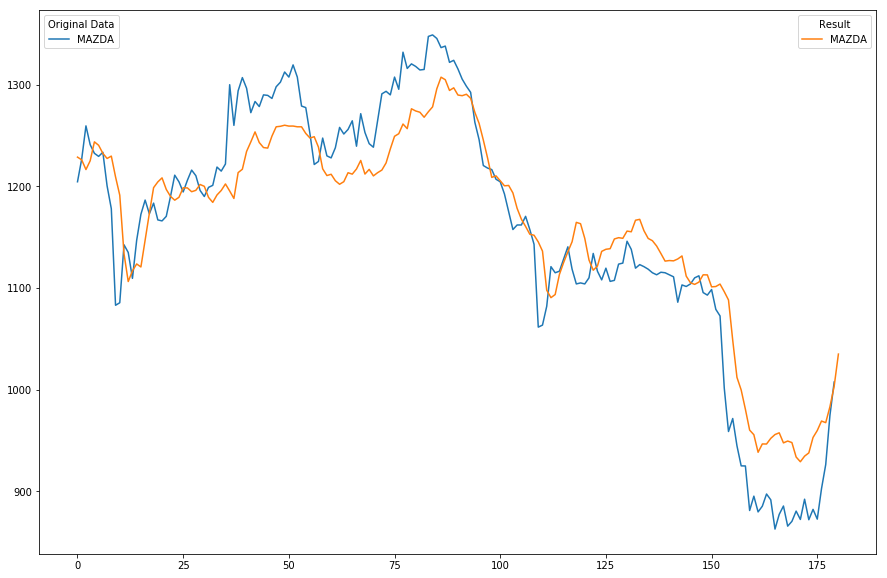

In [283]:
plt.figure(figsize=(15, 10))

p1 = plt.plot(dataframe.values[len(dataset)-val_days:len(dataset),0])
p2 = plt.plot(scaled_testPredict)

l1 = plt.legend(p1, legend_list, loc='upper left', title='Original Data')
l2 = plt.legend(p2, legend_list, loc='upper right', title='Result')

plt.gca().add_artist(l1) 
plt.show()
plt.close()

In [236]:
K.set_learning_phase(0)
ksess = K.get_session()
#print(ksess)

#K.set_learning_phase(0)
graph = ksess.graph
kgraph = graph.as_graph_def()
print(kgraph)

output_names = [node.op.name for node in model.outputs]
freeze_var_names = list(set(v.op.name for v in tf.global_variables()))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [237]:
# fix batch norm nodes
for node in kgraph.node:
    if node.op == 'RefSwitch':
        node.op = 'Switch'
        for index in range(len(node.input)):
            if 'moving_' in node.input[index] and "Switch" not in node.input[index]:
                node.input[index] = node.input[index] + '/read'
    elif node.op == 'AssignSub':
        node.op = 'Sub'
        if 'use_locking' in node.attr: del node.attr['use_locking']
    elif node.op == 'AssignAdd':
        node.op = 'Add'
        if 'use_locking' in node.attr: del node.attr['use_locking']

# convert variables in the model graph to constants
constant_graph = graph_util.convert_variables_to_constants(ksess, kgraph, output_names)
#constant_graph = mod_graph_util.convert_variables_to_constants(ksess, kgraph, output_names)

output_dir = "./"
output_graph_name = "stock_auto.pb"
output_text_name = "stock_auto.txt"
graph_io.write_graph(constant_graph, output_dir, output_graph_name, as_text=False)
graph_io.write_graph(constant_graph, output_dir, output_text_name, as_text=True)

INFO:tensorflow:Froze 9 variables.
INFO:tensorflow:Converted 9 variables to const ops.


'./stock_auto.txt'